In [235]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from io import StringIO
import geopy.distance # https://geopy.readthedocs.io/en/stable/#module-geopy.distance
import seaborn as sns
from scipy.spatial.distance import cdist
from scipy.optimize import minimize
from scipy.ndimage.interpolation import rotate

In [236]:
# https://www.latlong.net/category/cities-108-15.html
df = pd.read_csv(StringIO("""Place Name	Latitude	Longitude
Ra'anana, Israel	32.184448	34.870766
Bethlehem, Israel	31.705791	35.200657
Ashdod, Israel	31.801447	34.643497
Nazareth, Israel	32.699635	35.303547
Bat Yam, Tel-Aviv, Israel	32.017136	34.745441
Tel Aviv-Yafo, Israel	32.109333	34.855499
Haifa, Israel	32.794044	34.989571
Karmiel, Israel	32.919945	35.290146
Herzliya, Tel-Aviv, Israel	32.166313	34.843311
Rehovot, Israel	31.894756	34.809322
Jerusalem, Israel	31.771959	35.217018"""), sep='\t')
df

,Place Name,Latitude,Longitude
0,"Ra'anana, Israel",32.184448,34.870766
1,"Bethlehem, Israel",31.705791,35.200657
2,"Ashdod, Israel",31.801447,34.643497
3,"Nazareth, Israel",32.699635,35.303547
4,"Bat Yam, Tel-Aviv, Israel",32.017136,34.745441
5,"Tel Aviv-Yafo, Israel",32.109333,34.855499
6,"Haifa, Israel",32.794044,34.989571
7,"Karmiel, Israel",32.919945,35.290146
8,"Herzliya, Tel-Aviv, Israel",32.166313,34.843311
9,"Rehovot, Israel",31.894756,34.809322


In [237]:
cities = [x.partition(',')[0] for x in df['Place Name']]

In [238]:
# https://stackoverflow.com/questions/57294120/calculating-distance-between-latitude-and-longitude-in-python
lat_lon = df[['Latitude', 'Longitude']].values

D = cdist(
    lat_lon,
    lat_lon,
    lambda lat_lon1, lat_lon2: geopy.distance.distance(lat_lon1, lat_lon2).km
)
print(D[:3, :3])

[[ 0.         61.5626296  47.59132622]
 [61.5626296   0.         53.84305935]
 [47.59132622 53.84305935  0.        ]]


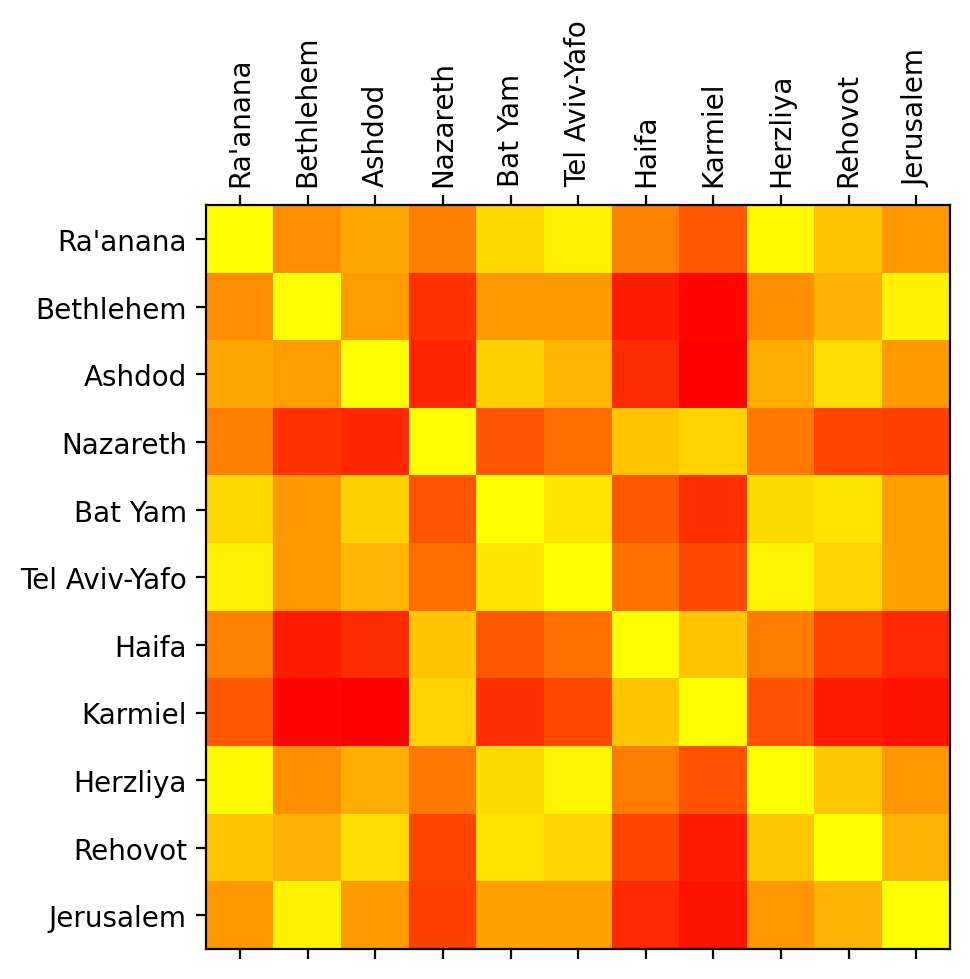

In [239]:
plt.matshow(D, cmap='autumn_r')
plt.xticks(np.arange(11), cities, rotation=90)
plt.yticks(np.arange(11), cities);

## Classical MDS

In [240]:
n = D.shape[0]
m = 2

In [241]:
D2 = D**2

I = np.eye(n)
J = np.ones(n)
C = I - J/n
B = -0.5 * C @ D2 @ C # Gram matrix

In [242]:
λ, E = np.linalg.eig(B)
idx = λ.argsort()[-m:]
print(idx)
λ = λ[idx]
E = E[idx].T
Λ = np.diag(λ)
X = E @ Λ**0.5

[1 0]


LOOKS BAD


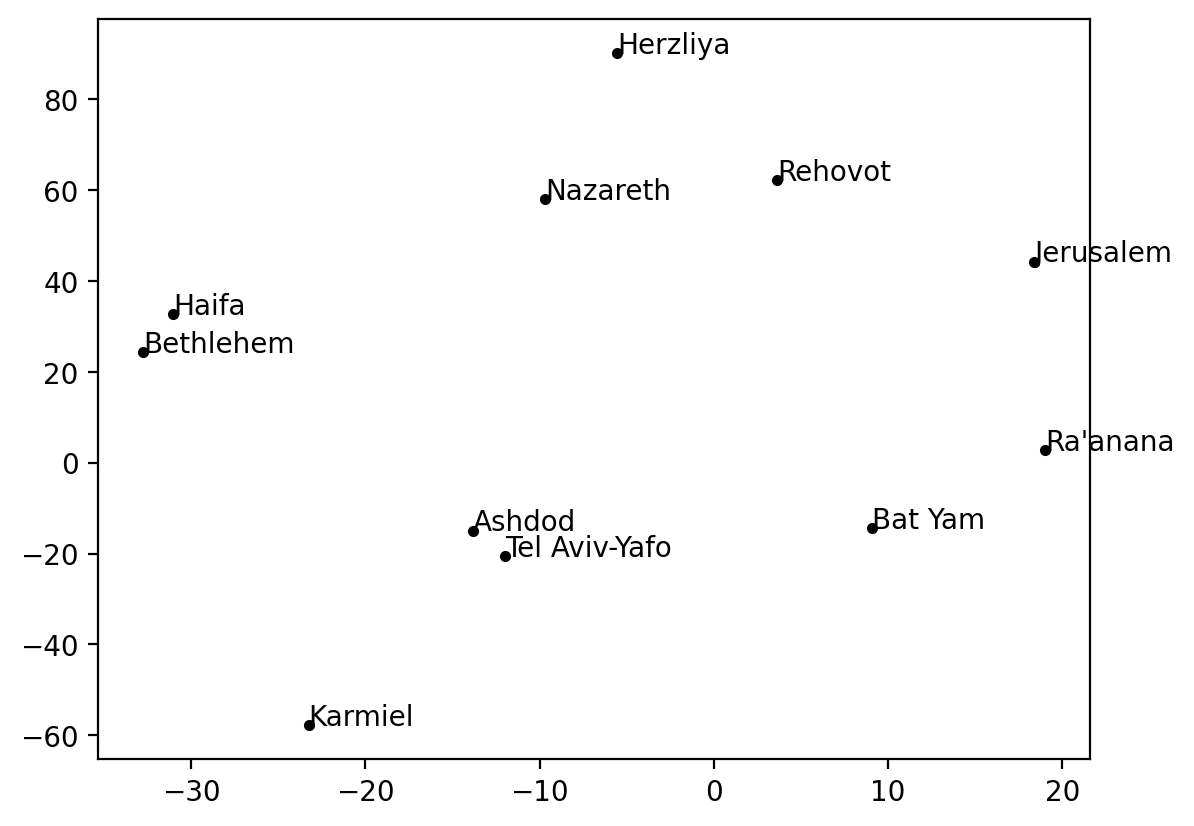

In [243]:
for city, (x, y) in zip(cities, X):
    plt.scatter(x, y, marker='.', color='k')
    plt.text(x, y, city)
print("LOOKS BAD")

## Metric MDS

In [280]:
def loss(X, D, p=1):
    X = X.reshape((n, 2))
    S = (D**p - scipy.spatial.distance.cdist(X, X))
    assert (S == S.T).all(), S
    assert (np.diag(S)==0).all(), np.diag(S)
    return np.sqrt((S*S).sum()/2)

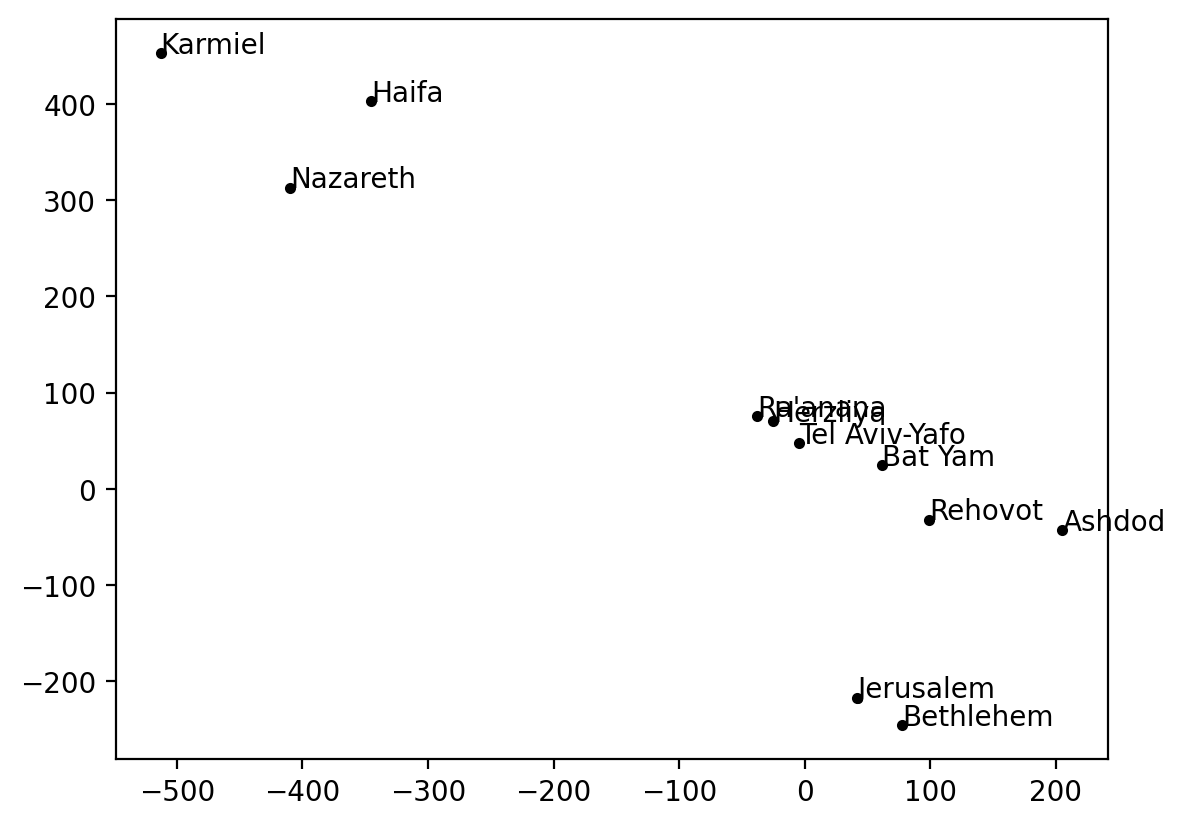

In [283]:
sol = minimize(loss, np.zeros(2*n), args=(D, 1.4))
assert sol.success
X = sol.x
X = X.reshape((n, 2))

for city, (x, y) in zip(cities, X):
    plt.scatter(-x, y, marker='.', color='k')
    plt.text(-x, y, city)

## Scikit-learn

In [246]:
from sklearn.manifold import MDS

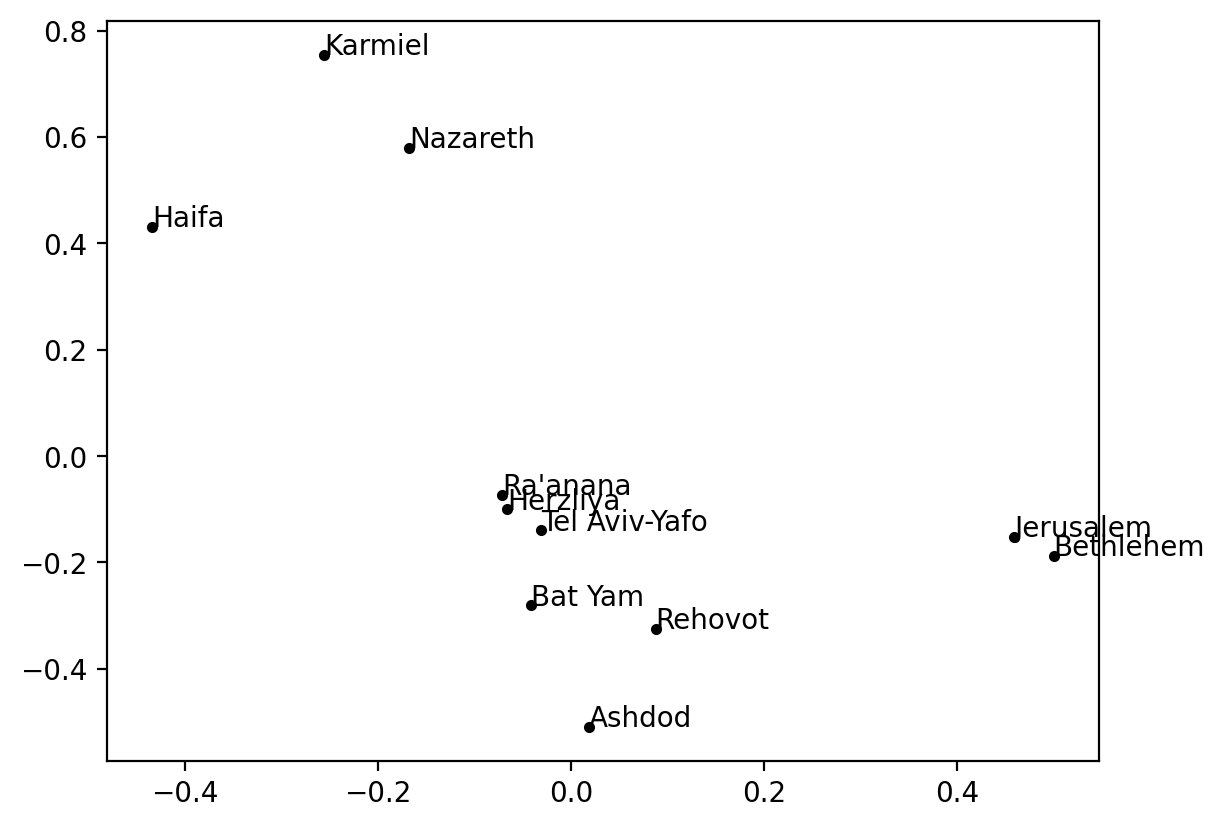

In [247]:
mds = MDS(random_state=12)
X = mds.fit_transform(lat_lon)

for city, (x, y) in zip(cities, X):
    plt.scatter(x, y, marker='.', color='k')
    plt.text(x, y, city)

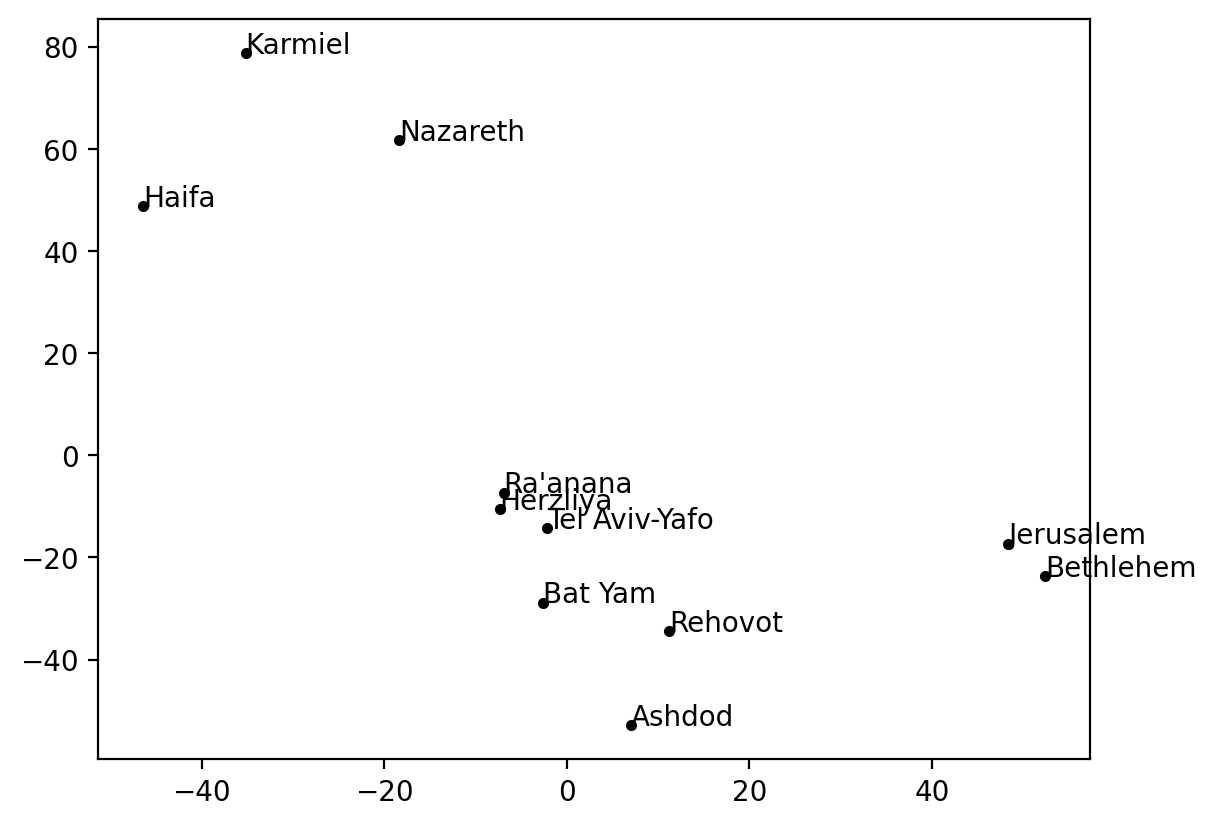

In [123]:
mds = MDS(dissimilarity='precomputed', random_state=12)
X = mds.fit_transform(D)

for city, (x, y) in zip(cities, X):
    plt.scatter(x, y, marker='.', color='k')
    plt.text(x, y, city)